<a href="https://colab.research.google.com/github/HEM2058/sentinelhub_remote_sensing/blob/main/RVI_NDVI_Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nearest available RVI (Sentinel-1) date: 2024-09-17
Nearest available NDVI (Sentinel-2) date: 2024-09-16
Overall Pearson correlation coefficient between RVI and NDVI: -0.032323302293057785


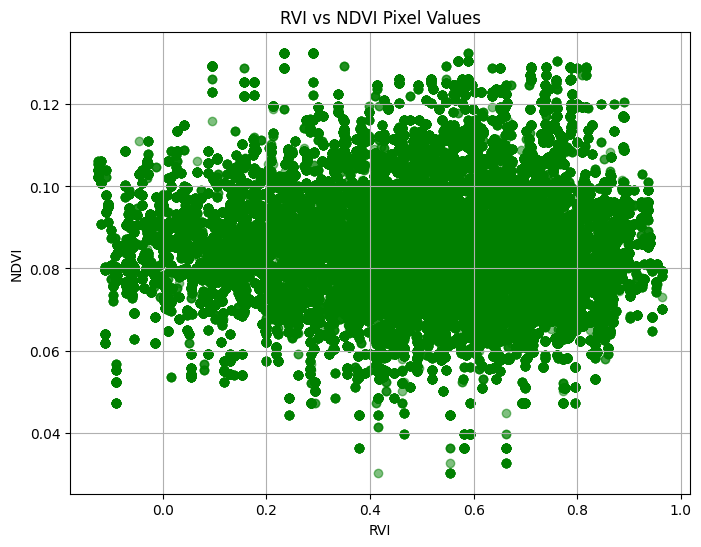

In [7]:
# Step 1: Install required packages
# (Ensure to install the required packages such as sentinelhub-py, numpy, matplotlib, etc.)

# Step 2: Import libraries
import numpy as np
import json
import matplotlib.pyplot as plt
from sentinelhub import SHConfig, SentinelHubRequest, MimeType, CRS, BBox, DataCollection, SentinelHubCatalog
import requests
from datetime import datetime, timedelta
from shapely.geometry import shape

# Configuration with Sentinel Hub credentials
config = SHConfig()
config.sh_client_id = '32b9acce-d3a2-4a47-b50e-ea52a441ab04'
config.sh_client_secret = 'D2FWFRrsh7MZTlbjqzS3lqlaTU1RM38j'

# Function to fetch available dates for RVI (Sentinel-1) and NDVI (Sentinel-2)
def fetch_available_dates(bbox, search_time_interval):
    catalog = SentinelHubCatalog(config=config)

    # Fetch Sentinel-1 data for RVI (Radar Vegetation Index)
    search_iterator_s1 = catalog.search(
        collection=DataCollection.SENTINEL1,
        bbox=bbox,
        time=search_time_interval
    )

    # Fetch Sentinel-2 data for NDVI (Normalized Difference Vegetation Index)
    search_iterator_s2 = catalog.search(
        collection=DataCollection.SENTINEL2_L2A,
        bbox=bbox,
        time=search_time_interval
    )

    # Get available dates for Sentinel-1 (RVI)
    available_dates_s1 = [feature['properties']['datetime'].split('T')[0] for feature in search_iterator_s1]

    # Get available dates for Sentinel-2 (NDVI)
    available_dates_s2 = [feature['properties']['datetime'].split('T')[0] for feature in search_iterator_s2]

    return available_dates_s1, available_dates_s2

# Function to find the nearest available date
def find_nearest_date(available_dates, input_date):
    input_date = datetime.strptime(input_date, "%Y-%m-%d")
    nearest_date = min(available_dates, key=lambda date: abs(datetime.strptime(date, "%Y-%m-%d") - input_date))
    return nearest_date

# Function to get Sentinel-1 RVI data
def get_rvi_data(bbox, date):
    evalscript_s1 = """
    //VERSION=3

    function setup() {
      return {
        input: ["VV", "VH", "dataMask"],
        output: { bands: 1, sampleType: "FLOAT32" }
      };
    }

    function evaluatePixel(sample) {
      let q = sample.VH / sample.VV;  // VH/VV ratio
      let N = q * (q + 3);
      let D = (q + 1) * (q + 1);
      let rvi = 1 - (N / D);
      return [rvi];
    }
    """
    request_s1 = SentinelHubRequest(
        evalscript=evalscript_s1,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL1,
                time_interval=(date, date),
            ),
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF),
        ],
        bbox=bbox,
        size=[512, 354.253],
        config=config,
    )

    response_s1 = request_s1.get_data()
    rvi_data = response_s1[0]
    return np.array(rvi_data, dtype=np.float32)

# Function to get Sentinel-2 NDVI data
def get_ndvi_data(bbox, date):
    evalscript_s2 = """
    //VERSION=3

    function setup() {
      return {
        input: ["B04", "B08", "dataMask"],  // Red (B4) and NIR (B8) bands
        output: { bands: 1, sampleType: "FLOAT32" }
      };
    }

    function evaluatePixel(sample) {
      let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);  // NDVI formula
      return [ndvi];
    }
    """
    request_s2 = SentinelHubRequest(
        evalscript=evalscript_s2,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=(date, date),
            ),
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF),
        ],
        bbox=bbox,
        size=[512, 354.253],
        config=config,
    )

    response_s2 = request_s2.get_data()
    ndvi_data = response_s2[0]
    return np.array(ndvi_data, dtype=np.float32)

# Function to compute the overall correlation between RVI and NDVI
def compute_overall_correlation(rvi_data, ndvi_data):
    # Ensure both arrays have the same shape
    if rvi_data.shape != ndvi_data.shape:
        raise ValueError("RVI and NDVI arrays have different shapes.")

    # Flatten the arrays to 1D, ignoring NaNs and infinite values
    rvi_flat = rvi_data.flatten()
    ndvi_flat = ndvi_data.flatten()

    # Filter out NaN and infinite values
    valid_mask = ~np.isnan(rvi_flat) & ~np.isnan(ndvi_flat) & ~np.isinf(rvi_flat) & ~np.isinf(ndvi_flat)
    rvi_flat_valid = rvi_flat[valid_mask]
    ndvi_flat_valid = ndvi_flat[valid_mask]

    # Compute the Pearson correlation coefficient
    correlation_coefficient = np.corrcoef(rvi_flat_valid, ndvi_flat_valid)[0, 1]

    return correlation_coefficient, rvi_flat_valid, ndvi_flat_valid

# Function to plot the scatter plot of RVI vs NDVI pixel values
def plot_rvi_vs_ndvi(rvi_values, ndvi_values):
    plt.figure(figsize=(8, 6))
    plt.scatter(rvi_values, ndvi_values, alpha=0.5, c='green')
    plt.title('RVI vs NDVI Pixel Values')
    plt.xlabel('RVI')
    plt.ylabel('NDVI')
    plt.grid(True)
    plt.show()

# Step 8: Input geometry and date
geojson_polygon = {
    "geometry": {
        "type": "Polygon",
        "coordinates": [[
            [83.93330352722262, 28.253973768350974],
            [83.93330352722262, 28.253659569839613],
            [83.93337632222165, 28.25319788871475],
            [83.93348551472019, 28.252934986069405],
            [83.9347594272034, 28.252357880429116],
            [83.93606973718789, 28.25212703729794],
            [83.93716166217348, 28.252210397375606],
            [83.9381807921618, 28.25294139833717],
            [83.93800608416376, 28.253909646281087],
            [83.93652106618299, 28.255153607555215],
            [83.93569848269306, 28.25565375284181],
            [83.93417706721112, 28.255224141006707],
            [83.93330352722262, 28.253973768350974]
        ]]
    }
}

# Date of interest
input_date = "2024-09-16"

# Step 9: Convert the polygon to a BBox
polygon = shape(geojson_polygon['geometry'])
bbox = BBox(bbox=polygon.bounds, crs=CRS.WGS84)

# Step 10: Define the search time interval ±10 days around the input date
search_time_interval = (
    (datetime.strptime(input_date, "%Y-%m-%d") - timedelta(days=10)).strftime("%Y-%m-%d"),
    (datetime.strptime(input_date, "%Y-%m-%d") + timedelta(days=10)).strftime("%Y-%m-%d")
)

# Step 11: Fetch the available dates for Sentinel-1 and Sentinel-2
available_dates_s1, available_dates_s2 = fetch_available_dates(bbox, search_time_interval)

# Step 12: Find the nearest available dates
nearest_rvi_date = find_nearest_date(available_dates_s1, input_date)
nearest_ndvi_date = find_nearest_date(available_dates_s2, input_date)

print(f"Nearest available RVI (Sentinel-1) date: {nearest_rvi_date}")
print(f"Nearest available NDVI (Sentinel-2) date: {nearest_ndvi_date}")

# Step 13: Fetch RVI and NDVI data for the nearest available dates
rvi_data = get_rvi_data(bbox, nearest_rvi_date)
ndvi_data = get_ndvi_data(bbox, nearest_ndvi_date)

# Step 14: Compute the overall correlation between RVI and NDVI
correlation_coefficient, rvi_values, ndvi_values = compute_overall_correlation(rvi_data, ndvi_data)

# Step 15: Print the correlation result and plot the graph
print(f"Overall Pearson correlation coefficient between RVI and NDVI: {correlation_coefficient}")

# Step 16: Plot the scatter plot of RVI vs NDVI
plot_rvi_vs_ndvi(rvi_values, ndvi_values)


Nearest available NDVI (Sentinel-2) date with <10% cloud cover: 2024-10-11, Cloud Cover: 7.44%
Nearest available RVI (Sentinel-1) date: 2024-10-11
Overall Pearson correlation coefficient between RVI and NDVI (low cloud cover): -0.03200873534631934


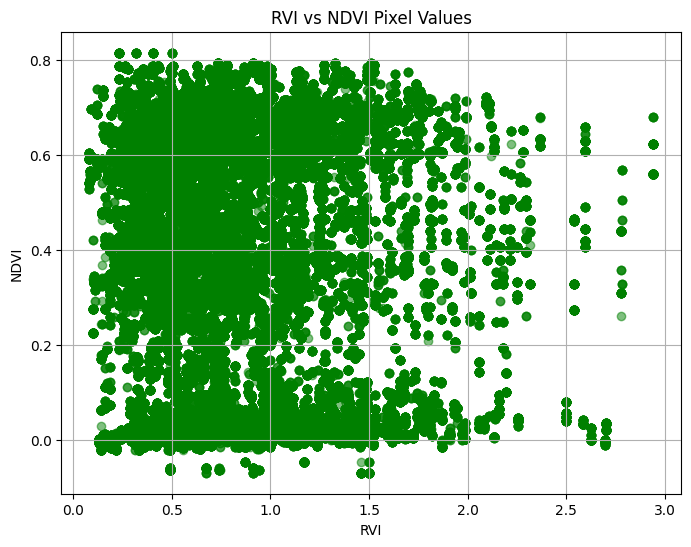

In [11]:
# Step 1: Install required packages (Make sure the required packages are installed)
# Example: !pip install sentinelhub numpy matplotlib

# Step 2: Import libraries
import numpy as np
import json
import matplotlib.pyplot as plt
from sentinelhub import SHConfig, SentinelHubRequest, MimeType, CRS, BBox, DataCollection, SentinelHubCatalog
from datetime import datetime, timedelta
from shapely.geometry import shape

# Step 3: Configuration with Sentinel Hub credentials
config = SHConfig()
config.sh_client_id = '32b9acce-d3a2-4a47-b50e-ea52a441ab04'
config.sh_client_secret = 'D2FWFRrsh7MZTlbjqzS3lqlaTU1RM38j'

# Step 4: Function to fetch available dates for Sentinel-2 with cloud cover filtering
def fetch_sentinel2_dates_with_cloud_cover(bbox, search_time_interval, cloud_cover_threshold=10):
    catalog = SentinelHubCatalog(config=config)

    # Search for Sentinel-2 data with cloud cover less than the specified threshold
    search_iterator_s2 = catalog.search(
        collection=DataCollection.SENTINEL2_L2A,
        bbox=bbox,
        filter=f"eo:cloud_cover < 10",  # Filter by cloud cover
        time=search_time_interval

    )

    # Extract the available dates and cloud cover percentages
    available_dates_s2 = [
        (feature['properties']['datetime'].split('T')[0], feature['properties']['eo:cloud_cover'])
        for feature in search_iterator_s2
    ]

    return available_dates_s2

# Step 5: Function to fetch available Sentinel-1 and Sentinel-2 dates
def fetch_available_dates(bbox, search_time_interval):
    catalog = SentinelHubCatalog(config=config)

    # Fetch Sentinel-1 data for RVI (Radar Vegetation Index)
    search_iterator_s1 = catalog.search(
        collection=DataCollection.SENTINEL1,
        bbox=bbox,
        time=search_time_interval
    )

    # Get available dates for Sentinel-1 (RVI)
    available_dates_s1 = [feature['properties']['datetime'].split('T')[0] for feature in search_iterator_s1]

    return available_dates_s1

# Step 6: Function to find the nearest available date
def find_nearest_date(available_dates, input_date):
    input_date = datetime.strptime(input_date, "%Y-%m-%d")
    nearest_date = min(available_dates, key=lambda date: abs(datetime.strptime(date, "%Y-%m-%d") - input_date))
    return nearest_date

# Step 7: Function to get Sentinel-1 RVI data
def get_rvi_data(bbox, date):
    evalscript_s1 = """
    //VERSION=3

    function setup() {
      return {
        input: ["VV", "VH", "dataMask"],
        output: { bands: 1, sampleType: "FLOAT32" }
      };
    }

    function evaluatePixel(sample) {
      let vv = sample.VV;
      let vh = sample.VH;

      // Calculate the Radar Vegetation Index (RVI)
      let rvi = (4 * vh) / (vv + vh);

      return [rvi];
    }
    """

    request_s1 = SentinelHubRequest(
        evalscript=evalscript_s1,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL1,
                time_interval=(date, date),
            ),
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF),
        ],
        bbox=bbox,
        size=[512, 354.253],
        config=config,
    )

    response_s1 = request_s1.get_data()
    rvi_data = response_s1[0]
    return np.array(rvi_data, dtype=np.float32)

# Step 8: Function to get Sentinel-2 NDVI data
def get_ndvi_data(bbox, date):
    evalscript_s2 = """
    //VERSION=3

    function setup() {
      return {
        input: ["B04", "B08", "dataMask"],  // Red (B4) and NIR (B8) bands
        output: { bands: 1, sampleType: "FLOAT32" }
      };
    }

    function evaluatePixel(sample) {
      let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);  // NDVI formula
      return [ndvi];
    }
    """
    request_s2 = SentinelHubRequest(
        evalscript=evalscript_s2,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=(date, date),
            ),
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF),
        ],
        bbox=bbox,
        size=[512, 354.253],
        config=config,
    )

    response_s2 = request_s2.get_data()
    ndvi_data = response_s2[0]
    return np.array(ndvi_data, dtype=np.float32)

# Step 9: Function to compute the overall correlation between RVI and NDVI
def compute_overall_correlation(rvi_data, ndvi_data):
    if rvi_data.shape != ndvi_data.shape:
        raise ValueError("RVI and NDVI arrays have different shapes.")

    # Flatten arrays and filter NaN and infinite values
    rvi_flat = rvi_data.flatten()
    ndvi_flat = ndvi_data.flatten()
    valid_mask = ~np.isnan(rvi_flat) & ~np.isnan(ndvi_flat) & ~np.isinf(rvi_flat) & ~np.isinf(ndvi_flat)
    rvi_flat_valid = rvi_flat[valid_mask]
    ndvi_flat_valid = ndvi_flat[valid_mask]

    correlation_coefficient = np.corrcoef(rvi_flat_valid, ndvi_flat_valid)[0, 1]

    return correlation_coefficient, rvi_flat_valid, ndvi_flat_valid

# Step 10: Function to plot the scatter plot of RVI vs NDVI pixel values
def plot_rvi_vs_ndvi(rvi_values, ndvi_values):
    plt.figure(figsize=(8, 6))
    plt.scatter(rvi_values, ndvi_values, alpha=0.5, c='green')
    plt.title('RVI vs NDVI Pixel Values')
    plt.xlabel('RVI')
    plt.ylabel('NDVI')
    plt.grid(True)
    plt.show()

# Step 11: Input geometry and date
geojson_polygon = {
    "geometry": {
        "type": "Polygon",
        "coordinates": [[
            [83.93330352722262, 28.253973768350974],
            [83.93330352722262, 28.253659569839613],
            [83.93337632222165, 28.25319788871475],
            [83.93348551472019, 28.252934986069405],
            [83.9347594272034, 28.252357880429116],
            [83.93606973718789, 28.25212703729794],
            [83.93716166217348, 28.252210397375606],
            [83.9381807921618, 28.25294139833717],
            [83.93800608416376, 28.253909646281087],
            [83.93652106618299, 28.255153607555215],
            [83.93569848269306, 28.25565375284181],
            [83.93417706721112, 28.255224141006707],
            [83.93330352722262, 28.253973768350974]
        ]]
    }
}

input_date = "2024-09-16"

# Step 12: Convert polygon to BBox
polygon = shape(geojson_polygon['geometry'])
bbox = BBox(bbox=polygon.bounds, crs=CRS.WGS84)

# Step 13: Define the search time interval ±10 days around the input date
search_time_interval = (
    (datetime.strptime(input_date, "%Y-%m-%d") - timedelta(days=60)).strftime("%Y-%m-%d"),
    (datetime.strptime(input_date, "%Y-%m-%d") + timedelta(days=60)).strftime("%Y-%m-%d")
)

# Step 14: Fetch available dates for Sentinel-2 with cloud cover less than 10%
available_dates_s2_cloud_filtered = fetch_sentinel2_dates_with_cloud_cover(bbox, search_time_interval)

# Step 15: If no suitable data found, print a message
if not available_dates_s2_cloud_filtered:
    print("No Sentinel-2 data found with less than 10% cloud cover.")
else:
    nearest_ndvi_date_cloud_filtered, cloud_cover_percentage = available_dates_s2_cloud_filtered[0]
    print(f"Nearest available NDVI (Sentinel-2) date with <10% cloud cover: {nearest_ndvi_date_cloud_filtered}, Cloud Cover: {cloud_cover_percentage}%")

    # Step 16: Fetch available dates for Sentinel-1
    available_dates_s1 = fetch_available_dates(bbox, search_time_interval)

    # Step 17: Fetch RVI data for the date closest to the NDVI date
    nearest_rvi_date_cloud_filtered = find_nearest_date(available_dates_s1, nearest_ndvi_date_cloud_filtered)
    print(f"Nearest available RVI (Sentinel-1) date: {nearest_rvi_date_cloud_filtered}")

    # Step 18: Fetch RVI and NDVI data for respective dates
    rvi_data_cloud_filtered = get_rvi_data(bbox, nearest_rvi_date_cloud_filtered)
    ndvi_data_cloud_filtered = get_ndvi_data(bbox, nearest_ndvi_date_cloud_filtered)

    # Step 19: Compute the correlation between RVI and NDVI
    correlation_coefficient_cloud_filtered, rvi_values_cloud_filtered, ndvi_values_cloud_filtered = compute_overall_correlation(rvi_data_cloud_filtered, ndvi_data_cloud_filtered)

    # Step 20: Print correlation result
    print(f"Overall Pearson correlation coefficient between RVI and NDVI (low cloud cover): {correlation_coefficient_cloud_filtered}")

    # Step 21: Plot the scatter plot of RVI vs NDVI for low cloud cover date
    plot_rvi_vs_ndvi(rvi_values_cloud_filtered, ndvi_values_cloud_filtered)


In [1]:
!pip install sentinelhub numpy requests geojson

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.8/249.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.8 MB/s eta 0:00:00
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6085 sha256=0f44e91093e5f92463c2e7a2499f120f9d098df4dbfd79faeffaef0463dff8b7
  Stored in directory: /root/.cache/pip/wheels/2f/a1/c8/543df0e8f5e824c3e92a432e32deb9cd89ae686095ee8cfcbe
Successfully built utm
